In [1]:
import pandas as pd
import numpy as np
from jupyter_utils import jupyter_setup
jupyter_setup()
import os
import librosa
import sounddevice as sd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
# import csv

D:\Archiv\Studium\Master\6.-Semester\Masters_Thesis\Git\acoustic_covid_detection\python


In [141]:
metadata_dicova = pd.read_csv(r"data\Coswara_processed\DiCova\SecondDiCOVA_detailed_test_metedata.csv")
full_metadata = pd.read_csv(r"data\Coswara_processed\full_meta_data.csv")
original_metadata = pd.read_csv(r"data\Coswara_processed\original_metadata.csv")
matches = pd.read_csv(r"matches_469.csv")

## remove all the IDs where I have already found matches

In [142]:
dicova_id_column = "BREATHING_ID"      # "COUGH_ID" "SPEECH_ID"  
dicova_subfolder = "breathing"           # "cough", "speech"
coswara_category = "breathing-deep"     # "cough-heavy","counting-normal"

In [143]:
dicova_reduced = pd.merge(matches, metadata_dicova, on=list(metadata_dicova.columns), how='outer')
dicova_reduced = dicova_reduced[dicova_reduced["user ID"].isna()]
metadata_dicova = dicova_reduced

In [5]:
#####################   tODO    ###################
# trim silence when calculating the audio length

In [6]:
class AudioData:
    def __init__(self, file_path, user_id, age, gender):
        audio, self.sr = librosa.load(file_path, sr=None)
        # audio, self.sr = librosa.load(file_path, sr=44100)
        # self.id = os.path.splitext(os.path.basename(full_path))[0]
        self.file_path= file_path
        self.id = user_id
        self.audio_len = len(audio) * (44100/self.sr)
        self.target_id = []
        self.gender = gender
        self.age =age
        self.correlations = {}
        self.best_fit = None
        self.downsample_coef = 32
        self.trim_silence_db = 30
        
    def __repr__(self):
        return f"id:{self.id} | len:{self.audio_len} | {self.gender}{self.age}"
            
    def __eq__(self, other):
        if isinstance(other, AudioData):
            return (
                self.audio_len == other.audio_len
                and self.gender == other.gender
                and self.age == other.age
            )
        return False        
    
    def eq_age_gender(self, other):
        if isinstance(other, AudioData):
            return (self.gender == other.gender and self.age == other.age)
        return False  
    
    def comapre_audio(self, other):
        sr = 44100//self.downsample_coef
        try:
            audio_orig, _ = librosa.load(self.file_path, sr=sr)
            audio_comp, _ = librosa.load(other.file_path, sr=sr)
            audio_orig, _ = librosa.effects.trim(audio_orig, top_db=self.trim_silence_db)
            audio_comp, _ = librosa.effects.trim(audio_comp, top_db=self.trim_silence_db)
            audio_orig, audio_comp = librosa.util.normalize(audio_orig), librosa.util.normalize(audio_comp)
        except:
            return 0
        
        
        # segment_len = 20000 if len(audio_orig) > 20000 else len(audio_orig)
        # segment_len = max(40000, len(audio_orig))
        # cross_corr = np.correlate(audio_orig[:segment_len], audio_comp, mode='full')
        cross_corr = np.correlate(audio_orig, audio_comp, mode='full')
        return cross_corr.max()
        
    def get_audio(self):
        audio_orig, _ = librosa.load(self.file_path, sr=44100//self.downsample_coef)
        audio_orig, _ = librosa.effects.trim(audio_orig, top_db=self.trim_silence_db)

        return librosa.util.normalize(audio_orig)

In [7]:
def get_audio(sample):
    file_path = sample.file_path
    audio_orig, _ = librosa.load(file_path, sr=44100//sample.downsample_coef)
    audio_orig, _ = librosa.effects.trim(audio_orig, top_db=sample.trim_silence_db)

    return librosa.util.normalize(audio_orig)

In [8]:
len(metadata_dicova)

21

In [9]:
# for full_id in list(full_metadata["user_id"])
dicova_audio_data = []
base_path = r"data\Coswara_processed\DiCova\Second_DiCOVA_Challenge_Test_Data_Release\AUDIO"
base_path = os.path.join(base_path, dicova_subfolder)

for breath_id in tqdm(list(metadata_dicova[dicova_id_column])):
    age = metadata_dicova[metadata_dicova[dicova_id_column] == breath_id]["age"].item()
    gender = metadata_dicova[metadata_dicova[dicova_id_column] == breath_id]["gender"].item()[0]
    full_path = f"{os.path.join(base_path, breath_id)}.flac"
    dicova_audio_data.append(AudioData(full_path, breath_id, age, gender))
    # print(full_path, age, gender)

  0%|          | 0/21 [00:00<?, ?it/s]

In [10]:
my_audio_data = []
base_path = r"data\Coswara_processed\Recordings"
for user_id in tqdm(list(full_metadata["user_id"])):
    age = full_metadata[full_metadata["user_id"] == user_id]["age"].item()
    gender = full_metadata[full_metadata["user_id"] == user_id]["gender"].item()[0]
    full_path = f"{os.path.join(base_path, user_id, coswara_category)}.wav"
    my_audio_data.append(AudioData(full_path, user_id, age, gender))
    # print(full_path, age, gender)

  0%|          | 0/2746 [00:00<?, ?it/s]

In [11]:
# base_path = r"data\Coswara_processed\Recordings"
# user_id = full_metadata["user_id"][1]
# full_path = f"{os.path.join(base_path, user_id, 'breathing-deep')}.wav"
# age = full_metadata[full_metadata["user_id"] == user_id]["age"].item()
# gender = full_metadata[full_metadata["user_id"] == user_id]["gender"].item()[0]
# audio_data1 = AudioData(full_path, user_id, age, gender)


# base_path = r"data\Coswara_processed\DiCova\Second_DiCOVA_Challenge_Test_Data_Release\AUDIO\breathing"
# breath_id = metadata_dicova[dicova_id_column][0]
# full_path = f"{os.path.join(base_path, breath_id)}.flac"
# age = metadata_dicova[metadata_dicova[dicova_id_column] == breath_id]["age"].item()
# gender = metadata_dicova[metadata_dicova[dicova_id_column] == breath_id]["gender"].item()[0]
# audio_data2 = AudioData(full_path, breath_id, age, gender)
# audio_data2, audio_data1

In [12]:
for dicova_id in dicova_audio_data:
    # print("############################################")
    dicova_id.target_id = []
    for my_id in my_audio_data:
        if dicova_id.eq_age_gender(my_id):
        # if dicova_id == my_id:
        # if np.abs(dicova_id.audio_len - my_id.audio_len) < 100:
            # diff = dicova_id.audio_len - my_id.audio_len
            # diff_percent = diff / dicova_id.audio_len * 100
            # diff_percent = np.round(diff_percent)
            # if np.abs(diff_percent) < 15:
            #     # print(diff_percent)
            #     dicova_id.target_id.append(my_id)
            dicova_id.target_id.append(my_id)

In [13]:
for dicova_id in dicova_audio_data:
    print(len(dicova_id.target_id))
    # print(dicova_id.sr)

54
35
68
87
54
14
101
70
22
14
19
14
33
83
70
15
87
37
17
25
42


In [ ]:
for sample in tqdm(dicova_audio_data):
    print("#################################")
    sample.best_fit = None
    max_corr = 0
    best_fit = None
    for user_id in sample.target_id:
        corr = sample.comapre_audio(user_id)
        sample.correlations[user_id.id] = corr
        print(round(corr, 1))
        if corr > max_corr:
            max_corr = corr
            best_fit = user_id
        if corr > 300:
            break
    sample.best_fit = best_fit

In [15]:
# for j in range(100, 110):
#     for i in range(1, 10):
#         print(i)
#         if j > 105:
#             break

In [16]:
len(dicova_audio_data)

21

In [17]:
actual_fits = {}
idx = 0

In [57]:
idx += 1
# print(idx)
target_audio = get_audio(dicova_audio_data[idx].best_fit)
# target_audio = dicova_audio_data[idx].best_fit.get_audio()
source_audio = get_audio(dicova_audio_data[idx])
# source_audio = dicova_audio_data[idx].get_audio()
plt.plot(target_audio)
plt.figure()
plt.plot(source_audio)
idx, dicova_audio_data[idx].correlations[dicova_audio_data[idx].best_fit.id]

IndexError: list index out of range

In [56]:
actual_fits[dicova_audio_data[idx].id] = dicova_audio_data[idx].best_fit.id
len(actual_fits)

19

In [58]:
dicova_id_column

'BREATHING_ID'

In [144]:
df = pd.DataFrame({dicova_id_column: actual_fits.keys(), "user ID":actual_fits.values()})

In [145]:
df

,BREATHING_ID,user ID
0,EKANDFRP,aGOvk4ji0cVqIzCs1jHnzlw2UEy2
1,IGDQHDOG,OCFaQR2Fa4S8cFiEJE2HueZH0TH3


In [146]:
metadata_dicova.drop("user ID", axis=1)

,BREATHING_ID,SPEECH_ID,COUGH_ID,FUSION_ID,COVID_STATUS,gender,age,covid_type,non_covid_healthy,non_covid_resp_ail,non_covid_but_covid_like_symp
469,EKANDFRP,VXCAIMWY,ZKCHFUEP,ASRQDLRT,n,m,32,none,True,False,False
470,IGDQHDOG,MMUJAHOZ,HWTLDCII,IIXZXUGQ,p,m,30,mild,False,False,False


## get all other metadata from the dicova df

In [147]:
new_matches = pd.merge(df, metadata_dicova.drop("user ID", axis=1), on=dicova_id_column, how='inner')
new_matches

,BREATHING_ID,user ID,SPEECH_ID,COUGH_ID,FUSION_ID,COVID_STATUS,gender,age,covid_type,non_covid_healthy,non_covid_resp_ail,non_covid_but_covid_like_symp
0,EKANDFRP,aGOvk4ji0cVqIzCs1jHnzlw2UEy2,VXCAIMWY,ZKCHFUEP,ASRQDLRT,n,m,32,none,True,False,False
1,IGDQHDOG,OCFaQR2Fa4S8cFiEJE2HueZH0TH3,MMUJAHOZ,HWTLDCII,IIXZXUGQ,p,m,30,mild,False,False,False


## combine with previously found matches

In [148]:
combined_matches = pd.concat([new_matches, matches])
combined_matches

,BREATHING_ID,user ID,SPEECH_ID,COUGH_ID,FUSION_ID,COVID_STATUS,gender,age,covid_type,non_covid_healthy,non_covid_resp_ail,non_covid_but_covid_like_symp
0,EKANDFRP,aGOvk4ji0cVqIzCs1jHnzlw2UEy2,VXCAIMWY,ZKCHFUEP,ASRQDLRT,n,m,32,none,True,False,False
1,IGDQHDOG,OCFaQR2Fa4S8cFiEJE2HueZH0TH3,MMUJAHOZ,HWTLDCII,IIXZXUGQ,p,m,30,mild,False,False,False
0,IXDFPYSU,A58ps4OZgaO0Y1E5rbeUBGJAxiW2,WFCWZPKX,QDZBYEFG,NOSCNYYC,n,m,38,none,True,False,False
1,COYWHFJC,796K27lWKTfniw99yaqsYIvPrvi1,EFLOKZAC,WQCMROKZ,QVLKXWWT,n,m,27,none,True,False,False
2,FBRBYSZR,euLpkmzCb1cGb2gkZRQ6gh7hGsC3,LQVELYVK,QQZYKVVY,TDMRNNUV,n,m,30,none,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
464,MZQROMRC,6GBpxEuVACapBiyIgwQOAj1zuuy1,ZBPYNBII,VUMDIGSR,YVRKYPIX,n,m,18,none,False,False,True
465,JYDRKQKC,6EIX9NrJ1oWfURDgcOsxZ8j4z5o2,HGOLGULC,RWGPYIIZ,SZRMFVSG,n,m,42,none,True,False,False
466,KUHCLGKW,6BGTwwcsLoZpqSMhSzFeT2Z7Pqr2,UUCORRLU,ELGZGLYC,XXSZQJYU,n,m,34,none,True,False,False
467,BDZJHRGG,MViWQGORcQfI5lGwqT4CDXP9iHG3,SOUBYDJB,NFYAWUEU,OFBYOEMF,n,m,45,none,True,False,False


In [149]:
combined_matches.to_csv("matches_471.csv", index=False)

In [ ]:
df.to_csv("temporary_id_relationshipts2.csv", index=False)

# read in saved matches

In [ ]:
matches = pd.read_csv(r"temporary_id_relationshipts2.csv")
matches

In [ ]:
merged_df = pd.merge(matches, metadata_dicova, on=dicova_id_column, how='inner')
merged_df

In [ ]:
merged_df.to_csv("matches_xxx.csv", index=False)

In [ ]:
temp_df = pd.merge(matches, metadata_dicova, on=dicova_id_column, how='outer')


In [ ]:
temp_df.il

In [ ]:
# temp_df.dropna(subset=["user ID"])
temp_df[temp_df["user ID"].isna()]

In [64]:
matches_as_list = list(new_matches[dicova_id_column])

In [65]:
dicova_audio_data_reduced = [sample for sample in dicova_audio_data if sample.id not in matches_as_list]

In [85]:
len(dicova_audio_data_reduced)

2

In [67]:
dicova_audio_data_reduced[0].correlations

{'aGOvk4ji0cVqIzCs1jHnzlw2UEy2': 342.15924}

In [130]:
actual_fits = {}
idx = -1

(0, 342.15924)

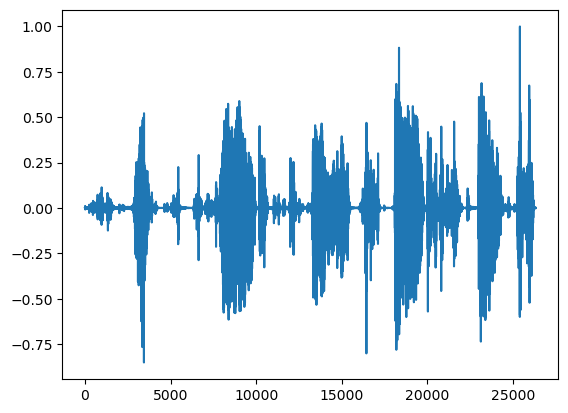

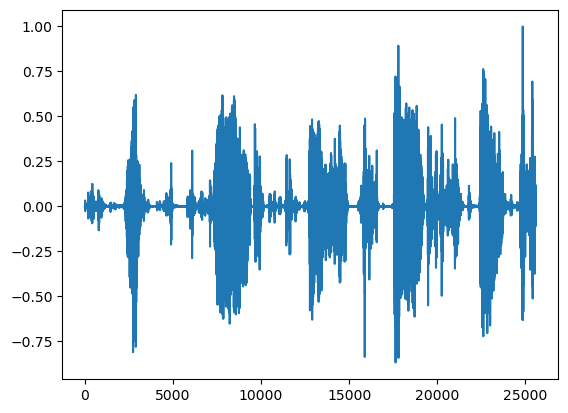

In [131]:
# print(idx)
idx += 1
target_audio = dicova_audio_data_reduced[idx].best_fit.get_audio()
source_audio = dicova_audio_data_reduced[idx].get_audio()
plt.plot(target_audio)
plt.figure()
plt.plot(source_audio)
idx, dicova_audio_data_reduced[idx].correlations[dicova_audio_data_reduced[idx].best_fit.id]


In [118]:
best_corr_ids = [key for key, val in dicova_audio_data_reduced[idx].correlations.items() if val > 3]

In [119]:
my_audio_data2 = []
base_path = r"data\Coswara_processed\Recordings"
for user_id in best_corr_ids:
    age = full_metadata[full_metadata["user_id"] == user_id]["age"].item()
    gender = full_metadata[full_metadata["user_id"] == user_id]["gender"].item()[0]
    full_path = f"{os.path.join(base_path, user_id, coswara_category)}.wav"
    my_audio_data2.append(AudioData(full_path, user_id, age, gender))
    # print(full_path, age, gender)

In [121]:
best_fits = [x for x in my_audio_data2 if x.audio_len > 350000 and x.audio_len < 450000]

In [113]:
 dicova_audio_data_reduced[idx].audio_len

400312.0

In [134]:
idx

0

In [138]:
dicova_audio_data_reduced[idx].best_fit.id

'aGOvk4ji0cVqIzCs1jHnzlw2UEy2'

In [139]:
actual_fits[dicova_audio_data_reduced[0].id] = dicova_audio_data_reduced[0].best_fit.id
actual_fits

{'EKANDFRP': 'aGOvk4ji0cVqIzCs1jHnzlw2UEy2',
 'IGDQHDOG': 'OCFaQR2Fa4S8cFiEJE2HueZH0TH3'}

('OCFaQR2Fa4S8cFiEJE2HueZH0TH3', 'IGDQHDOG')

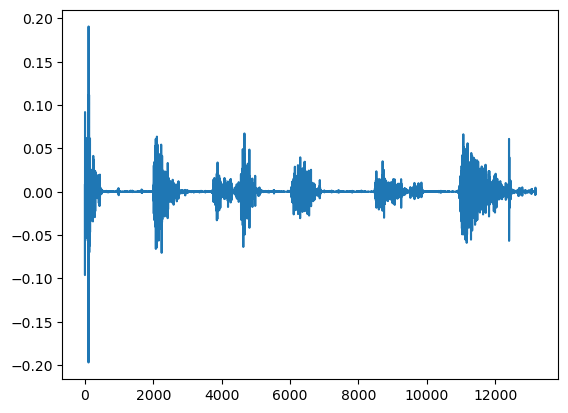

In [127]:
temp_audio = best_fits[1].get_audio()
plt.plot(temp_audio[100:])
best_fits[1].id, dicova_audio_data_reduced[idx].id

In [ ]:
import sounddevice as sd

In [78]:
play_n_seconds=3
sr = 44100//dicova_audio_data_reduced[idx].downsample_coef

In [79]:
sd.play(target_audio[:play_n_seconds*sr], sr)

In [80]:
sd.play(source_audio[:play_n_seconds*sr], sr)